In [2]:
cd /private/home/ccaucheteux/hasson-syntaxe-vs-semantics/

/private/home/ccaucheteux/hasson-syntaxe-vs-semantics


In [43]:
from src.get_features import load_precomputed_features
from src import paths
import torch
import spacy
from src.preprocess_stim import get_stimulus
import numpy as np

In [18]:
nlp = spacy.load("en_core_web_sm")

# Function to probe

In [126]:
import networkx as nx

def get_ranks(x, *args, **kwargs):
    """
    Replaces values by rank
    """
    idx = np.argsort(x, *args, **kwargs)
    ranks = np.empty_like(idx)
    ranks[idx] = np.arange(len(x))
    return ranks


def correlate(X, Y, spearman=True):
    """
    Fast pearsonr (or spearmanr) correlation across first dimension
    """
    if spearman:
        X = get_ranks(X, axis=0)
        Y = get_ranks(Y, axis=0)

    if X.ndim == 1:
        X = X[:, None]
    if Y.ndim == 1:
        Y = Y[:, None]
    out = np.zeros(max([Y.shape[1], X.shape[1]]))
    X = X - X.mean(0)
    Y = Y - Y.mean(0)

    SX2 = (X ** 2).sum(0) ** 0.5
    SY2 = (Y ** 2).sum(0) ** 0.5
    SXY = (X * Y).sum(0)
    # alid = (SX2 != 0) & (SY2 != 0)
    # out[valid] = SXY[valid] / (SX2[valid] * SY2[valid])
    out = SXY / (SX2 * SY2)
    return out


def get_distance_matrix(doc):
    """
    Return distance matrix of
    """
    if len(doc) == 0:
        return np.zeros((0, 0))

    edges = []
    for token in doc:
        for child in token.children:
            edges.append((token.i, child.i))
    graph = nx.Graph(edges)

    distances = nx.all_pairs_shortest_path_length(graph)

    matrix = np.zeros((len(doc), len(doc)), dtype=int)
    for i, d in distances:
        if not len(d):
            continue
        matrix[i, list(d.keys())] = list(d.values())
    #upper_tri = np.triu_indices(len(doc))
    return matrix #[upper_tri]


def format_text(text):
    text = text.replace('\n', ' ')
    text = text.replace(' -- ', '. ')
    text = text.replace(' – ', ', ')
    text = text.replace('–', '-')
    text = text.replace(' "', '. ')
    text = text.replace(' "', '. ')
    text = text.replace('" ', '. ')
    text = text.replace('". ', '. ')
    text = text.replace('." ', '. ')
    text = text.replace('?. ', '? ')
    text = text.replace(',. ', ', ')
    text = text.replace('...', '. ')
    text = text.replace('.. ', '. ')
    text = text.replace(':', '. ')
    text = text.replace('…', '. ')
    text = text.replace('-', ' ')
    text = text.replace('  ', ' ')
    text = text.lower()
    return text


# Check if we can decode nlp spacy word embeddings

In [352]:
from sklearn.model_selection import cross_val_predict
def predict_word_emb(tasks, cv=10):
    
    feats = {"X":[], "Xbar":[], "Y":[]}
    r = {}
    
    for task in tasks:
        
        print(task)
        
        # Features
        stim = get_stimulus(task, lower=False)
        stim["idx"] = range(len(stim))
        stim["task"] = task
        X = torch.load(emb_dir / task / "sum-gpt2-9.pth")
        Xbar = torch.load(emb_dir / task / "sum-gpt2-9.equiv-random-mean-10.pth")
        if len(X) != len(stim) or len(Xbar) != len(stim):
            print(task, len(X), len(stim), len(Xbar))
            continue
        words = stim.word_low.values
        
        # Validate
        valid = np.where([(type(w) is str and w != '<unk>' and len(w)>0) for w in words])[0]
        words = words[valid]
        Xbar = Xbar[valid]
        X = X[valid]
        
        # Extract vectors
        vectors = [nlp(str(i))[0].vector for i in words]
        vectors = np.stack(vectors)
        
        feats["X"].append(X)
        feats["Xbar"].append(Xbar)
        feats["Y"].append(vectors)
        
    feats = {k:np.concatenate(v, axis=0) for k,v in feats.items()}
    
    model = RidgeCV(np.logspace(-3, 3, 10))
    X_sem = cross_val_predict(model, feats["Xbar"], feats["X"], cv=cv)
    X_sem = feats["X"] - X_sem
    
    print("init model")
    r["init"] = cross_val_score(model, feats["X"], feats["Y"], cv=cv)
    r["syn"] = cross_val_score(model, feats["Xbar"], feats["Y"], cv=cv)
    r["sem"] = cross_val_score(model, feats["X"]-feats["Xbar"], feats["Y"], cv=cv)
    r["sem_ro"] = cross_val_score(model, X_sem, feats["Y"], cv=cv)
    
    return r

In [353]:
tasks = ['pieman', 'tunnel', 'slumlordreach', 'notthefallintact', 'lucy',
       'prettymouth', 'shapessocial', 'shapesphysical', 'merlin',
       'sherlock', '21styear', 'piemanpni', 'bronx', 'forgot', 'black']
r = predict_word_emb(tasks, cv=10)

pieman
tunnel
slumlordreach
notthefallintact
lucy
prettymouth
shapessocial
shapesphysical
merlin
sherlock
21styear
piemanpni
bronx
forgot
black
init model


In [355]:
[1, 2, 3, 4][:None]

[1, 2, 3, 4]

In [354]:
r

{'init': array([0.62226083, 0.64943745, 0.64384728, 0.63675116, 0.59739581,
        0.66391316, 0.62288288, 0.61840842, 0.63348749, 0.63696784]),
 'syn': array([ 0.15431253,  0.23203482,  0.37991854, -0.02745471,  0.25596333,
         0.28030274, -0.10035061, -0.10007872,  0.25432665,  0.04123123]),
 'sem': array([0.38630631, 0.39232654, 0.31635884, 0.42614233, 0.31886268,
        0.38254738, 0.43417949, 0.42904162, 0.35431909, 0.40171744])}

In [316]:
task = "sherlock"
emb_dir = paths.embeddings / "0206_wordembed" 
stimulus = get_stimulus(task, lower=False)
stimulus["idx"] = range(len(stimulus))

X = torch.load(emb_dir / task / "sum-gpt2-9.pth")
Xbar = torch.load(emb_dir / task / "sum-gpt2-9.equiv-random-mean-10.pth")

words = stimulus.word_low.values
valid = np.where([(type(w) is str and w != '<unk>' and len(w)>0) for w in words])[0]
words = words[valid]
Xbar = Xbar[valid]
X = X[valid]

In [320]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold
model = RidgeCV(np.logspace(-3, 3, 10))
cross_val_score(model, X, vectors, cv=5)

array([0.60307786, 0.59310622, 0.62606894, 0.60707138, 0.58132359])

In [321]:
cross_val_score(model, Xbar, vectors, cv=5)

array([0.48716432, 0.48415741, 0.48622465, 0.47209298, 0.45854675])

In [322]:
cross_val_score(model, X-Xbar, vectors, cv=5)

array([0.31674116, 0.27484019, 0.31027321, 0.2993781 , 0.24428777])

In [240]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold
model = RidgeCV(np.logspace(-3, 3, 10))
cross_val_score(model, X, vectors, cv=5)

array([0.38787452, 0.45078134, 0.44401124, 0.45512142, 0.46998054])

In [241]:
cross_val_score(model, Xbar, vectors, cv=5)

array([0.35643896, 0.35791424, 0.34973531, 0.37810422, 0.36977464])

In [ ]:
cross_val_score(model, Xbar, vectors, cv=5)

In [ ]:
# variance expliquee uniquement syntaxique (les representations des mots qui ont la meme fonction dans la phrase seront proche)
# => grande distance entre mes samples si POS TAG different par exemple. 
# 

In [312]:
from sklearn.decomposition import PCA
reconstructed = PCA(2).fit_transform(Xbar)

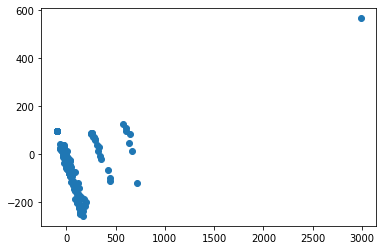

In [314]:
plt.plot(reconstructed[:, 0], reconstructed[:, 1], 'o')

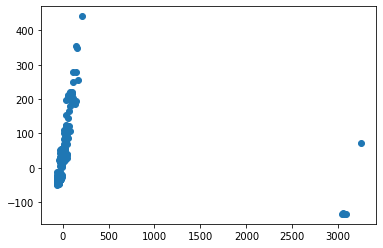

In [315]:
reconstructed = PCA(2).fit_transform(X)
plt.plot(reconstructed[:, 0], reconstructed[:, 1], 'o')

# Check if we can predict the tree depth

In [279]:
doc = nlp("I am a cat.")

def get_root(doc):
    edges = []
    root = None
    invalid = False
    for token in doc:
        if token.dep_ == "ROOT":
            if root is not None:
                print("invalid root", doc)
            root = token.i
            invalid = True
        for child in token.children:
            edges.append((token.i, child.i))

    if root is None or invalid:
        return -1
    else:
        return root
    
def get_depth(doc):
    root = get_root(doc)
    print("root", root)
    distances = get_distance_matrix(doc)
    depth = distances[:, root]
    return depth

In [296]:
df = stimulus.copy()
depths = []
for i, group in df.groupby("sequ_index"):
    sent = " ".join(group.word)
    doc = nlp(sent)
    depth = get_depth(doc)
    if len(doc) == len(group) == len(depth):
        depths.extend(depth)
    else:
        depths.extend([-1]*len(group))

root -1
root -1
invalid root So I whip out my notebook and I go up to him and I say Dean McGowan is it true that Fordham University plans to raise tuition substantially above the inflation rate and if so wouldn’t that be a betrayal of its mission
invalid root So I whip out my notebook and I go up to him and I say Dean McGowan is it true that Fordham University plans to raise tuition substantially above the inflation rate and if so wouldn’t that be a betrayal of its mission
root -1
invalid root And he stops and looks at me and he says Listen up punk
root -1
invalid root And right then there’s a blur in the corner of my eye which becomes this figure holding a cream pie which becomes the guy standing next to me mashing a cream pie into Dean McGowan’s face
root -1
root -1
root -1
invalid root So I give him a moment and then I say Dean McGowan would you care to comment on this latest attack
root -1
root -1
root -1
invalid root So I race back to the newsroom with my scoop and I find the edit

In [304]:
X = torch.load(emb_dir / task / "sum-gpt2-9.pth")
Xbar = torch.load(emb_dir / task / "sum-gpt2-9.equiv-random-mean-10.pth")


Y = np.array(depths)
valid = np.where(Y>=0)[0]
Y = Y[valid]
Xbar = Xbar[valid]
X = X[valid]

from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold
model = RidgeCV(np.logspace(-3, 3, 10))
cross_val_score(model, X, Y, cv=5)

array([-0.19232354, -0.82818452, -0.3525399 ,  0.00852734, -0.54127317])

In [305]:
cross_val_score(model, Xbar, Y, cv=5)

array([-0.07529677, -0.21171834,  0.11906521,  0.01609575, -0.40396547])

# Check syntactic properties of the syntactic embeddings

In [3]:
# Syntactic distances between syntactic embedding and true syntactic tree. Syntactic vs Semantic. 
# Semantic distances betwen word embeddings ? Regress out syntax in the word embedding. Correlation between distances. 

# Probing tasks (presence of syntax) : decode number of opening nodes, tree depth, syntactic features etc. 
# Probing tasks (absence of semantic) : decode the abstract vs concrete aspect of nouns. Compare between syntax and semantics. 



In [177]:
from src.task_dataset import get_task_df
tasks = get_task_df().audio_task.unique()

In [228]:
emb_dir = paths.embeddings / "0206_wordembed" 
task = "pieman"
X = torch.load(emb_dir / task / "sum-gpt2-0.pth")
Xbar = torch.load(emb_dir / task / "sum-gpt2-0.equiv-random-mean-10.pth")

stimulus = []
for task in tasks[:2]:
    stim = get_stimulus(task, lower=False)
    stim["idx"] = range(len(stim))
    stim["task"] = task
    stimulus.append(stim)
    
stimulus = pd.concat(stimulus, axis=0)


In [231]:
from sklearn.metrics import pairwise_distances
import pandas as pd
from sklearn.metrics import pairwise_distances
from tqdm.notebook import tqdm

def get_corr_syntactic_distance(emb_dir, stimulus, metric="cosine", corr_fun=spearmanr):
    corr = []

    for task, df in stimulus.groupby("task"):

        X = torch.load(emb_dir / task / "sum-gpt2-9.pth")
        Xbar = torch.load(emb_dir / task / "sum-gpt2-9.equiv-random-mean-10.pth")

        for s, group in tqdm(df.groupby("sequ_index")):

            sent = " ".join(group.word.values)
            idx = group.idx.values
            doc = nlp(sent)
            if len(doc) != len(group) or len(doc)<5:
                continue

            triu = np.triu_indices(len(doc))
            true_dist = get_distance_matrix(doc)

            syn_dist = pairwise_distances(Xbar[idx], metric=metric)
            syn_corr = corr_fun(syn_dist[triu], true_dist[triu])

            sem_dist = pairwise_distances(X[idx] - Xbar[idx], metric=metric)
            sem_corr = corr_fun(sem_dist[triu], true_dist[triu])

            init_dist = pairwise_distances(X[idx], metric=metric)
            init_corr = corr_fun(init_dist[triu], true_dist[triu])

            corr.append({"sequ_index": s,
                         "task":task,
                         "sequ_len":len(group),
                         "sem_corr": sem_corr[0],  #correlate(syn_dist[triu], true_dist[triu], False), 
                         "syn_corr": syn_corr[0],  #correlate(sem_dist[triu], true_dist[triu], False), 
                         "init_corr":init_corr[0],
                        #""})
                         "sem_pval": sem_corr[1],  
                         "syn_pval": syn_corr[1],  


                        })
    corr = pd.DataFrame(corr)
    return corr

In [232]:
import matplotlib.pyplot as plt

euclidean pearsonr


/private/home/ccaucheteux/.conda/envs/hasson/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())



euclidean spearmanr


/private/home/ccaucheteux/.conda/envs/hasson/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())



cosine pearsonr


/private/home/ccaucheteux/.conda/envs/hasson/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())



cosine spearmanr


/private/home/ccaucheteux/.conda/envs/hasson/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


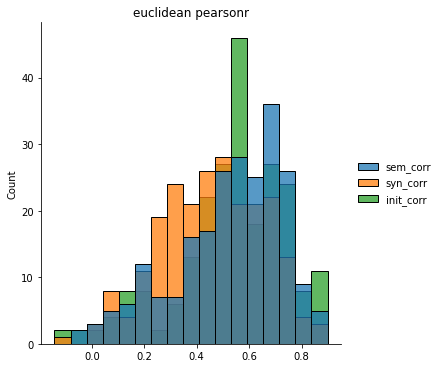

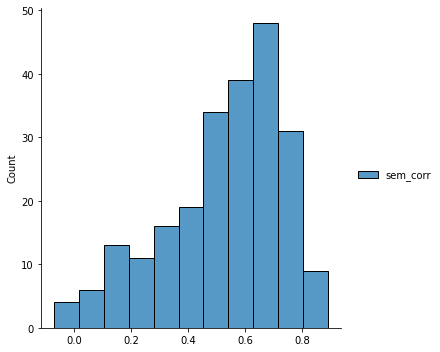

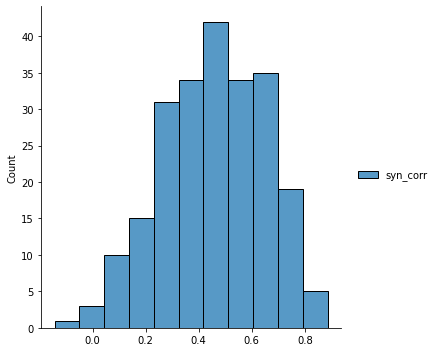

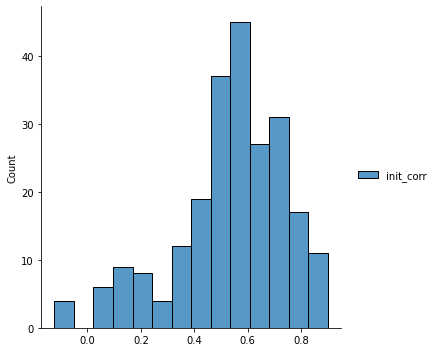

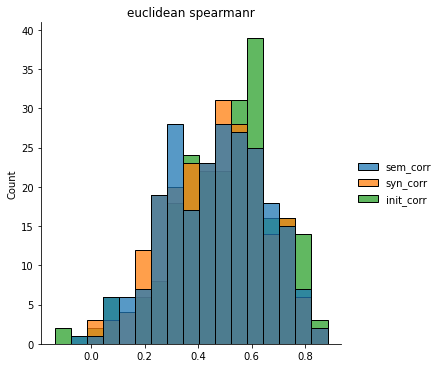

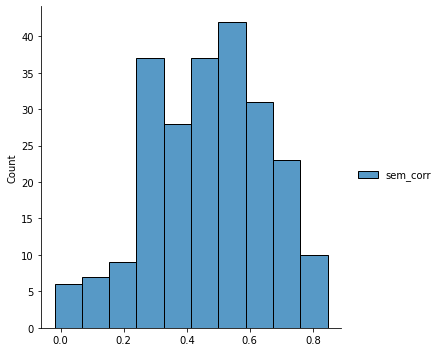

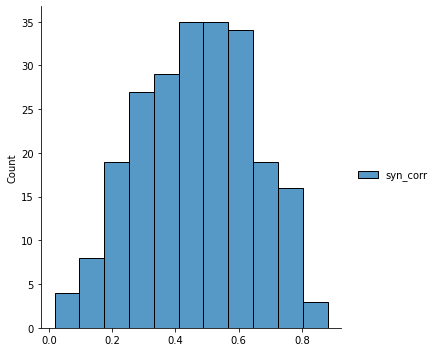

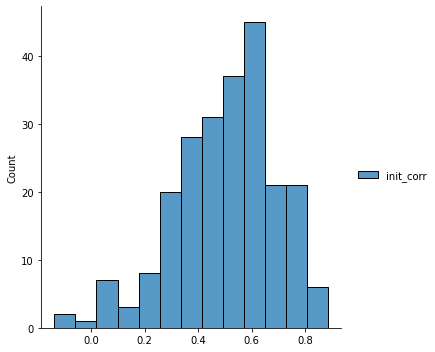

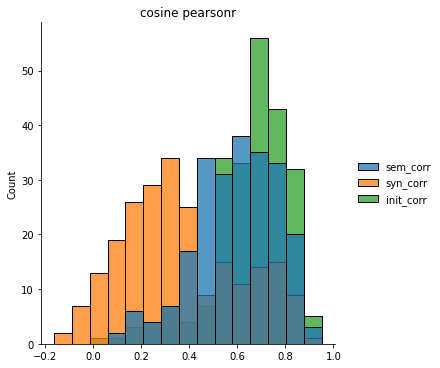

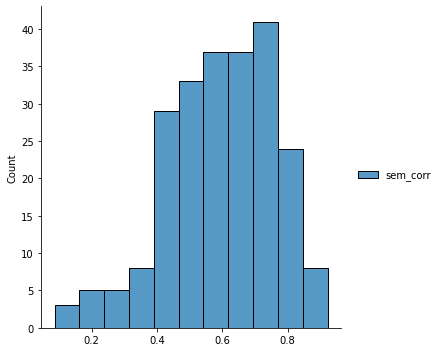

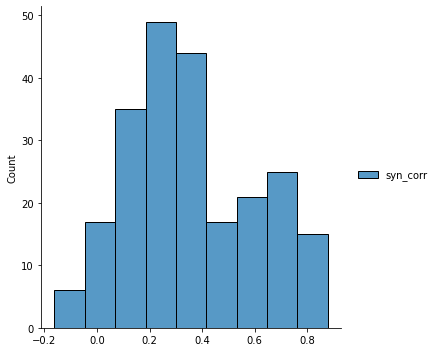

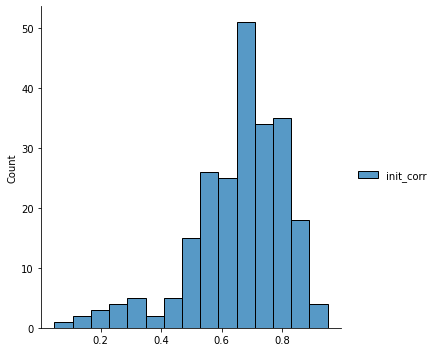

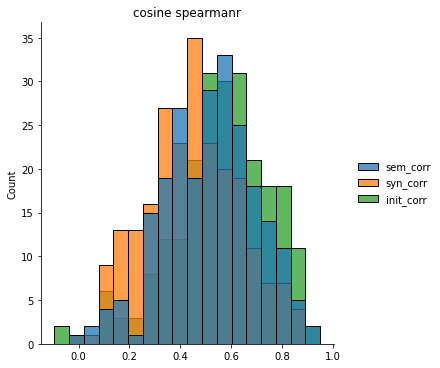

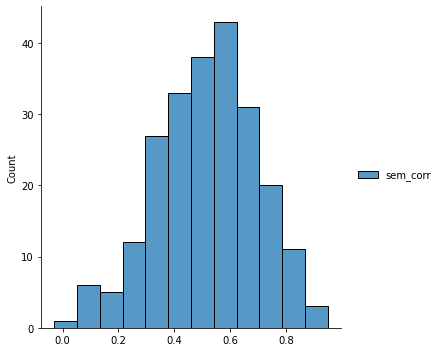

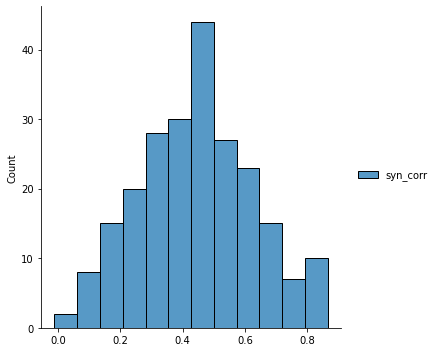

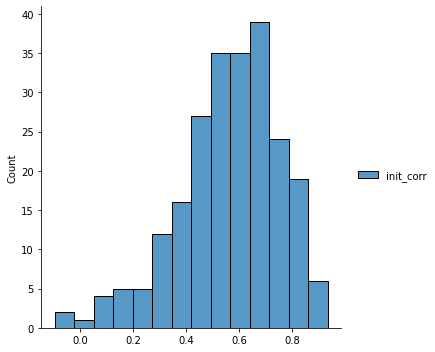

In [233]:
for metric in ["euclidean", "cosine"]:
    for corr_fun_name in ["pearsonr", "spearmanr"]:
        corr_fun = pearsonr if corr_fun_name == "pearsonr" else spearmanr
        print(metric, corr_fun_name)
        corr = get_corr_syntactic_distance(emb_dir, stimulus, metric=metric, corr_fun=corr_fun)
        sns.displot(corr[["sem_corr", "syn_corr", "init_corr"]])
        plt.title(f"{metric} {corr_fun_name}")
        sns.displot(corr[["sem_corr"]])
        sns.displot(corr[["syn_corr"]])
        sns.displot(corr[["init_corr"]])

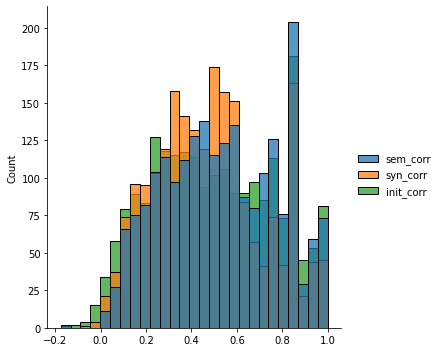

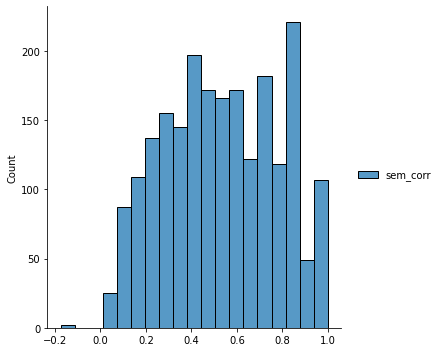

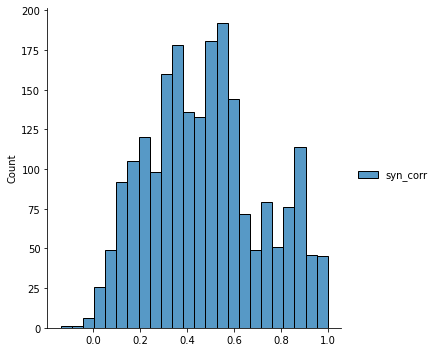

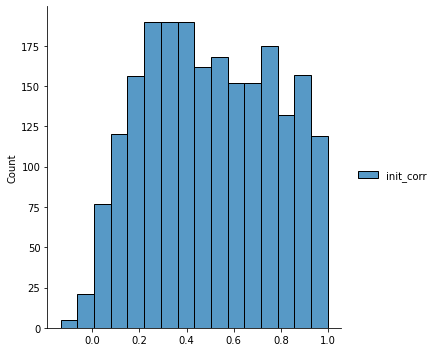

In [190]:
import seaborn as sns
sns.displot(corr[["sem_corr", "syn_corr", "init_corr"]])
sns.displot(corr[["sem_corr"]])
sns.displot(corr[["syn_corr"]])
sns.displot(corr[["init_corr"]])

In [99]:
from scipy.stats import spearmanr, pearsonr

In [100]:
pearsonr(true_dist[0], sem_dist[0])

(0.6697779577065952, 0.024157180555361743)

In [91]:
correlate(sym_dist, true_dist).shape

<ipython-input-86-24eea92bc20a>:34: RuntimeWarning: invalid value encountered in true_divide
  out = SXY / (SX2 * SY2)


(11,)

In [83]:
true_dist[:3, :3]

array([[0, 1, 2],
       [1, 0, 1],
       [2, 1, 0]])

In [82]:
sem_dist[:3, :3]

array([[0.0000000e+00, 9.9470508e-01, 9.6660948e-01],
       [9.9470508e-01, 0.0000000e+00, 9.2899919e-01],
       [9.6660948e-01, 9.2899919e-01, 5.9604645e-08]], dtype=float32)

In [80]:
sem_dist.shape

(11, 11)

In [63]:
words = stimulus.word.values
for sent, l in zip(sentences, sentlen):
    idx = 
    doc = nlp(sent)
    dist = get_distance_matrix(doc)
    if len(dist) != l:
        print(len(dist), l, sent)

36 34 And one day I’m walking toward the campus center and out comes the elusive Dean McGowan architect of a policy to replace Fordham’s traditionally working to middle class students with wealthier more prestigious ones
44 43 So I whip out my notebook and I go up to him and I say Dean McGowan is it true that Fordham University plans to raise tuition substantially above the inflation rate and if so wouldn’t that be a betrayal of its mission
38 36 And right then there’s a blur in the corner of my eye which becomes this figure holding a cream pie which becomes the guy standing next to me mashing a cream pie into Dean McGowan’s face
40 38 So I race back to the newsroom with my scoop and I find the editor Jim Dwyer who’s a senior and he will go on to win a Pulitzer Prize that is true and he’s a big guy
22 20 I pitch him my story I tell him what I’ve seen and he says Dean McGowan that guy’s a dick
27 25 So I’m banging out my story and I know it’s good and then I start to make it better by a

In [ ]:
def get_manning_proj_embeddings(word_events):

    probe_layer = 16

    # Params
    args = {
        "model": {
            "hidden_dim": 1024,
            "model_type": "BERT-disk",
            "use_disk": False,
            "model_layer": probe_layer,
        },
        "probe": {
            "task_name": "demo",
            "maximum_rank": 1024,
            "psd_parameters": True,
            "depth_params_path": paths.probe_path
            / "example/data/bertlarge16-depth-probe.params",
            "distance_params_path": paths.probe_path
            / "example/data/bertlarge16-distance-probe.params",
        },
        "reporting": {"root": paths.probe_path / "example/results"},
        "device": "cpu",
    }

    # Define the distance probe
    with torch.no_grad():
        distance_probe = probe.TwoWordPSDProbe(args)
        distance_probe.load_state_dict(
            torch.load(
                args["probe"]["distance_params_path"], map_location=args["device"]
            )
        )

        # Extract 16 layer representation from bert-large-cased ONLY (pretrained)
        feats = get_ptpb_transformer_embeddings(
            word_events, model_name="bert-large-cased"
        )

        assert feats.shape == (
            24,
            len(word_events),
            1024,
        )  # check right model, with hugginface add embedding layer
        feats = feats[probe_layer]  # only layer 16
        feats = feats @ distance_probe.proj

    return feats.detach()